In [1]:
using ForwardDiff
using Plots
using SimpleSolvers

using ForwardDiff

using LinearAlgebra
using LogExpFunctions, Distances
using WassersteinDictionaries

using Optim, LineSearches
using LinearMaps, IterativeSolvers

using Statistics

In [475]:
const d = 2
const N = 128
const N₁ = N
const N₂ = N

x₁ = collect(range(0,1,length=N₁))
x₂ = collect(range(0,1,length=N₂));

h₁ = 1/N₁
h₂ = 1/N₂

ci = CartesianIndices(x₁*x₂')
li = LinearIndices(x₁*x₂');

N₁ * N₂

16384

In [476]:
### Operators

# homogeneous B.C.
function __eval(f::AbstractVector{T},i,j,ci,li) where T
    n₁, n₂ = size(ci)
    if i < 1 || j < 1 || i > n₁ || j > n₂
        return zero(T)
    else
        return f[ li[ i,j ] ]
    end
end

# periodic B.C.
function __eval_per(f::AbstractVector{T},i,j,ci,li) where T
    n₁, n₂ = size(ci)
    if i < 1
        i = n₁ - i
    end
    if j < 1
        j = n₂ - j
    end
    if i > n₁
        i = i - n₁
    end
    if j > n₂
        j = j - n₂
    end

    return f[ li[ i,j ] ]

end

function _apply_∇σ∇!(y::AbstractVector, x::AbstractVector, σ::AbstractVector, ci, li, h₁, h₂) # 2D Laplace operator
    n₁, n₂ = size(ci)
    length(x) == length(y) == length(σ) || throw(DimensionMismatch())

        _eval(x,i,j) = __eval(x,i,j,ci,li) 

    @inbounds for ij in li
        i,j = Tuple(ci[ij])

        ∂xx = ( (_eval(x,i+1,j) - x[ij])*(_eval(σ,i+1,j) + σ[ij])
                + (_eval(x,i-1,j) - x[ij])*(_eval(σ,i-1,j) + σ[ij]) ) / 2 / h₁ / h₁ 

        ∂yy = ( (_eval(x,i,j+1) - x[ij])*(_eval(σ,i,j+1) + σ[ij])
                + (_eval(x,i,j-1) - x[ij])*(_eval(σ,i,j-1) + σ[ij]) ) / 2 / h₂ / h₂ 


        y[ij] = ∂xx + ∂yy
    end
end

_ones = ones(N₁*N₂)
_closure_apply_∇_∇!(y,x) = _apply_∇σ∇!(y,x,_ones,ci,li,h₁,h₂) 
Δ = LinearMap(_closure_apply_∇_∇!, N₁*N₂; issymmetric=true, ismutating=true )

κ = ones(N₁*N₂)
_closure_apply_∇κ∇!(y,x) = _apply_∇σ∇!(y,x,κ,ci,li,h₁,h₂) 
∇κ∇ = LinearMap(_closure_apply_∇κ∇!, N₁*N₂; issymmetric=true, ismutating=true )

function _do_nothing!(y::AbstractVector, x::AbstractVector)
    y .= x
end

Id = LinearMap(_do_nothing!, _do_nothing!, N₁*N₂; ismutating=true, issymmetric=false);

In [1234]:
μ₁ = range(-0.1,0.1,length=7)
μ₂ = μ₁

F = zeros(N₁*N₂, length( μ₁ ) * length( μ₂ ) )
K = zeros(N₁*N₂, length( μ₁ ) * length( μ₂ ) )
f = zeros(N₁*N₂)

κ = ones(N₁*N₂)
src = ones(N₁*N₂)

_i = 1

for _μ₁ in μ₁
    for _μ₂ in μ₂

    x_μ = [0.5 + _μ₁, 0.5 + _μ₂]
    
    # set up κ
    src .= 1
    κ .= 0.1
    for ij in li
        i,j = Tuple(ci[ij])
        if norm( [x₁[i], x₂[j]] - x_μ, Inf ) ≤ 0.25
            κ[ij] += 0.9
            #src[ij] = 1
        end
        #if norm( [x₁[i], x₂[j]] - x_μ, Inf ) ≤ 0.1
        #    src[ij] = 1
        #end
    end

    cg!(f, -∇κ∇, src)
    F[:,_i] .= f
    K[:,_i] .= κ
    #F[:,_i] .= vec( [ exp( -((_x-x_μ[1])^2 + (_y-x_μ[2])^2) / 0.0025 ) for _x in x₁, _y in x₂ ] )
    _i += 1

    end
end

In [1235]:
nₚ = size(F,2)

49

In [1437]:
ε = 5e-3

SP = SinkhornParameters(64, ε)
SPB = SinkhornParameters(256, ε)

c = WassersteinDictionaries.get_cost_matrix_separated(N, d);
k = WassersteinDictionaries.get_gibbs_matrix( c, ε)

α_indices = 1:nₚ
α = [ reshape(F[:,s],N₁,N₂) for s in α_indices ]

for s in eachindex(α)
    #α[s] .-= 0.1
    α[s] ./= (sum(α[s])*h₁*h₂);
end

log_α = [ log.(α[s]) for s in α_indices ]
nₛ = length(α)

a₀ = ones(size(α[1])); b₀ = ones(size(α[1]))
d₀₁ = ones(size(α[1])); d₀₂ = ones(size(α[1]));

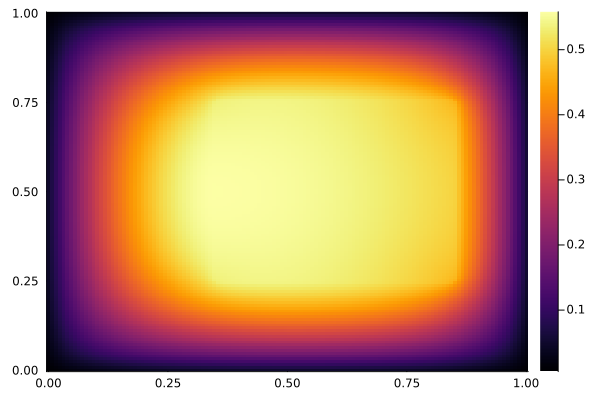

In [1438]:
heatmap(x₁, x₂, reshape(F[:,rand(1:nₛ)],N₁,N₂))

In [1439]:
### Reference = Barycenter
β_indices = 1:nₛ
nβₛ = length(β_indices)

a_₀ = [ones(size(α[s])) for s in β_indices] 
d₀ = ones(size(α[1]));

caches = ( MC = MatrixCache(nβₛ,N), VMC = VectorMatrixCache(nβₛ,N), VC = VectorCache(nβₛ,N) )

SPB.L = 256
SPB.tol = 1e-9 * h₁ * h₂

SPB.debias = false
SPB.averaged_updates = false
SPB.update_potentials = true
#β = sinkhorn_barycenter_sep([ 1/nβₛ for _ in 1:nβₛ ], α[β_indices], a_₀, d₀, k, SPB, caches);
#β = reshape(_ones, N₁, N₂)
β = α[ div(end,2)+1 ];

In [1440]:
c_max = maximum(maximum.(α))

1.6171106769194834

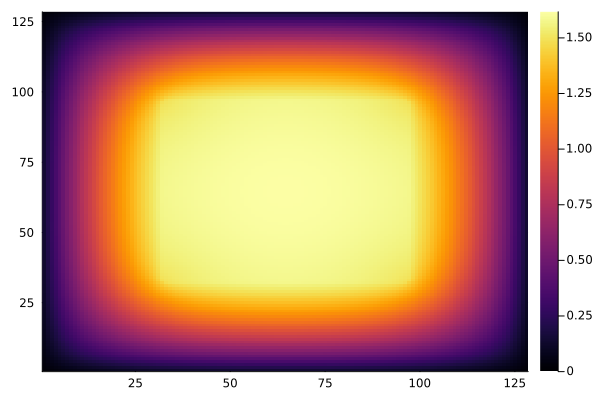

In [1441]:
heatmap(β, clim = (0,c_max))

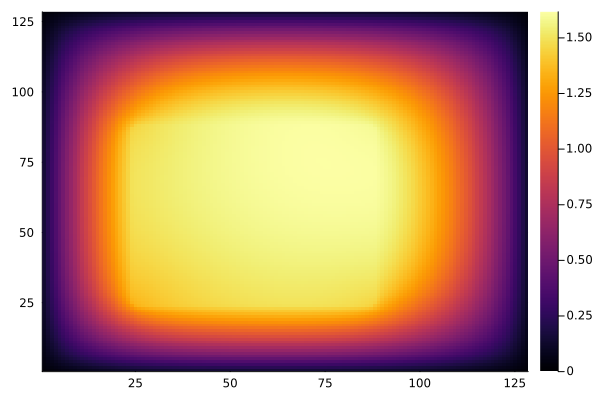

In [1442]:
heatmap(α[rand(1:nₛ)], clim = (0,c_max))

In [1443]:
x² = [ x^2 + y^2 for x in x₁, y in x₂ ];

In [1444]:
## If σ is given: need to compute transport potentials from α[s] to σ
ψ  = [ones(size(α[s])) for s in eachindex(α)] # ψ = f
ψᶜ = [ones(size(α[s])) for s in eachindex(α)];

SP.L = 128
SP.tol = 1e-9 * h₁ * h₂

SP.debias = false
SP.averaged_updates = false
SP.update_potentials = true

for s in eachindex(α)

    a₀ .= 1.0
    b₀ .= 1.0

    #ψ[s] .= log.(a_₀[s]) .* ε # if barycenter has been computed from all snaps

    sinkhorn_dvg_sep( α[s], β, a₀, b₀, d₀₁, d₀₂, k, SP, caches)
    ψ[s] .= log.(a₀) * ε

    WassersteinDictionaries.softmin_separated!(ψᶜ[s], ψ[s], log.(α[s]), 1e-9, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
end

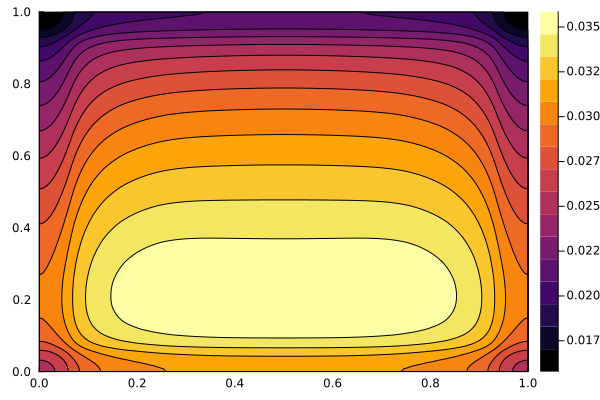

In [1445]:
__i = rand(1:nₛ)
contourf(x₁, x₂, (ψᶜ[__i]))

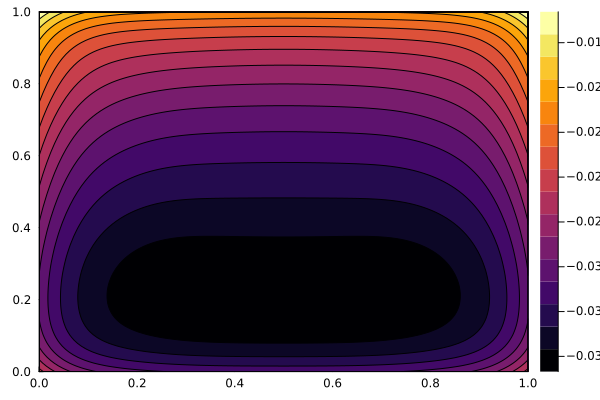

In [1446]:
contourf(x₁, x₂, (ψ[__i]))

In [1447]:
# Reference H1 norm
_closure_apply_∇σ∇!(y,x) = _apply_∇σ∇!(y,x,vec(β),ci,li,h₁,h₂)
∇σ∇ = LinearMap(_closure_apply_∇σ∇!, N₁*N₂; issymmetric=true, ismutating=true );

In [1448]:
Ψᶜ = zeros(N₁*N₂,nₛ)
S = zeros(N₁*N₂,nₛ)
for s in 1:nₛ
    Ψᶜ[:,s] = vec(ψᶜ[s])
    S[:,s] = F[:,s]
end

In [1505]:
KΨᶜ = - h₁ * h₂ * Matrix(Ψᶜ' * ∇σ∇ * Ψᶜ) ;
evdS = eigen( Matrix(S' * -Δ * S) * h₁ * h₂, sortby = x -> -abs(x) )
evdΨᶜ = eigen(0.5 * (KΨᶜ' + KΨᶜ) , sortby = x -> -abs(x) );

ΛS = abs.(evdS.values);
ΛΨᶜ = abs.(evdΨᶜ.values);

In [1506]:
US = S * evdS.vectors * diagm(1 ./ sqrt.(abs.(ΛS)) )
UΨᶜ = Ψᶜ * evdΨᶜ.vectors * diagm(1 ./ sqrt.(abs.(ΛΨᶜ)) )
ES = [ sum(ΛS[1:k]) / sum(ΛS) for k in 1:length(ΛS)];
EΨᶜ = [ sum(ΛΨᶜ[1:k]) / sum(ΛΨᶜ) for k in 1:length(ΛΨᶜ)];

In [1507]:
pal = cgrad(:viridis, 5, categorical=true);
ΛS[1], ΛΨᶜ[1]

(7.406547104609733, 0.9387621296098265)

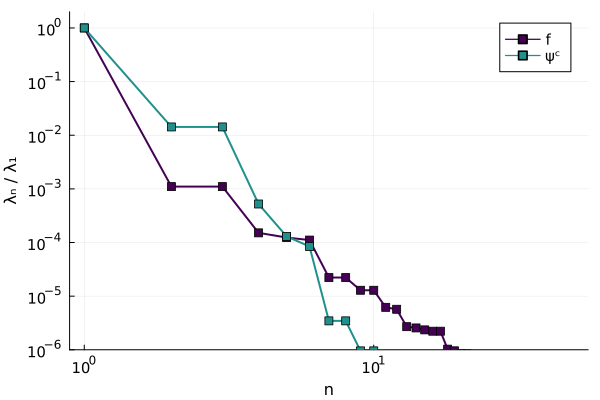

In [1508]:
plot(ΛS ./ ΛS[1],  yaxis=:log, xaxis = :log, linewidth=2, marker = :square, xlabel = "n", ylabel = "λₙ / λ₁", ylim = (1e-6, 2),
c=pal[1], legend = :topright, label = "f",legendfontsize=10, tickfontsize = 10) 
plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[3], marker = :square, label = "ψᶜ" )

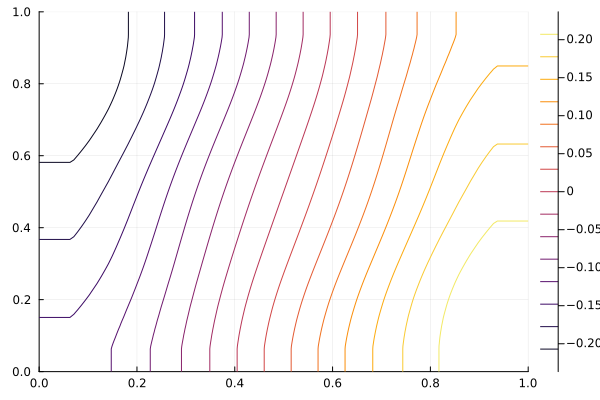

In [1509]:
contour(x₁, x₂, UΨᶜ[:,2])

In [1510]:
function _∇ψ♯!(∇ψ♯f, f::AbstractVector{T}, ψᶜ) where T

    n₁, n₂ = size(ci)

    for ij in li

        ∇ψ♯f[ij] = zero(T)
        i,j = Tuple(ci[ij])

        i == 1 ? i₋ = i : i₋ = i-1
        i == n₁ ? i₊ = i : i₊ = i+1

        j == 1 ? j₋ = j : j₋ = j-1
        j == n₂ ? j₊ = j : j₊ = j+1
        
        dy₁ = -1 / (i₊-i₋) / h₁ * ( ψᶜ[li[i₊,j]] - ψᶜ[li[i₋,j]] )
        dy₂ = -1 / (j₊-j₋) / h₂ * ( ψᶜ[li[i,j₊]] - ψᶜ[li[i,j₋]] )

        ### find y + ∇ψᶜ(y)

        i₋ = i + Int(floor(dy₁/h₁)) # index left of y + ∇ψᶜ(y)
        j₋ = j + Int(floor(dy₂/h₂)) # indices below y + ∇ψᶜ(y)

        if i₋ < 1 || i₋ > n₁ || j₋ < 1 || j₋ > n₂
            continue  # y + ∇ψᶜ(y) ∉ Ω, assume f(y ∉ Ω) = 0.
        end

        dy₁ < 0 ? a = 1 + (dy₁ % h₁) / h₁ : a = (dy₁ % h₁) / h₁ # distance between y₁ + ∂₁ψᶜ(y) and the index to the left
        dy₂ < 0 ? b = 1 + (dy₂ % h₂) / h₂ : b = (dy₂ % h₂) / h₂

        #i₋ == n₁ ? i₊ = i₋ : i₊ = i₋+1
        #j₋ == n₂ ? j₊ = j₋ : j₊ = j₋+1 # repeat values outside of the domain

        i₋ == n₁ ? f₊₋ = zero(T) : f₊₋ = f[ li[i₋+1,j₋] ]
        j₋ == n₂ ? f₋₊ = zero(T) : f₋₊ = f[ li[i₋,j₋+1] ]
        j₋ == n₂ || i₋ == n₁ ? f₊₊ = zero(T) : f₊₊ = f[ li[i₊,j₊] ] # extend by zero outside the domain

        f₋₋ = f[ li[i₋,j₋] ]
        #f₊₋ = f[ li[i₊,j₋] ]
        #f₋₊ = f[ li[i₋,j₊] ]
        #f₊₊ = f[ li[i₊,j₊] ]

        fₓ₁ = (1-a) * f₋₋ + a * f₊₋
        fₓ₂ = (1-a) * f₋₊ + a * f₊₊

        ∇ψ♯f[ij] = (1-b) * fₓ₁ + b * fₓ₂
    end
end

_∇ψ♯! (generic function with 1 method)

In [1511]:
### for plots

ΛT♯S_ = zeros(nₛ,5)

for m in 1:3

    if m != 0

            # transport basis
            Ξ = UΨᶜ[:,1:m]
            # transport coefficients
            λ = [ - h₁ * h₂ * Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ]
            
            # approximate mappings from reference configuration 
            ψᶜλ = [ reshape(Ξ * λ[s], N₁, N₂) for s in eachindex(ψᶜ) ];
            # approximate mappingsto reference configuration
            ψλ = [ones(size(α[s])) for s in eachindex(α)]
            for s in eachindex(ψλ)
                WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
            end

            # snapshots in the reference frame
            T♯S = zero(S)
            T♯αᵢ = zeros(N₁*N₂)
            for i in eachindex(α)
                _∇ψ♯!(T♯αᵢ, S[:,i], vec(ψᶜλ[i]))
                T♯S[:,i] .= T♯αᵢ
            end

    end

    # get the reduced Basis
    KT♯S = Matrix(T♯S' * -Δ * T♯S) * h₁ * h₂
    evdT♯S = eigen( 0.5 *( KT♯S + KT♯S'), sortby = x -> -abs(x) )
    ΛT♯S_[:,m] = evdT♯S.values
    #ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
    #UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) );
end

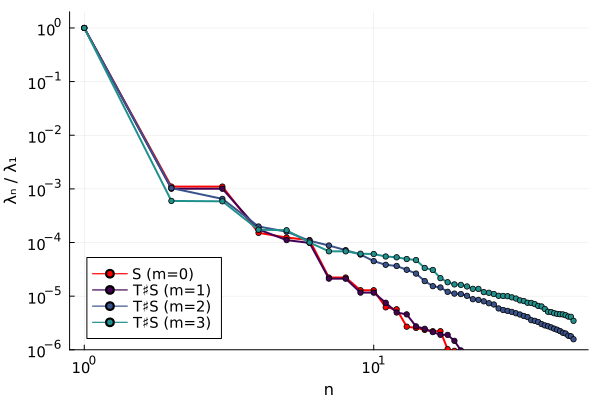

In [1512]:
plt = plot(ΛS ./ ΛS[1],  yaxis=:log, xaxis = :log, linewidth=2, marker = :c, markersize = 3, xlabel = "n", ylabel = "λₙ / λ₁", ylim = (1e-6, 2),
c=:red, legend = :bottomleft, label = "S (m=0)",legendfontsize=10, tickfontsize = 10) 
#plot!(ΛΨᶜ ./ ΛΨᶜ[1], linewidth=2, c=pal[2], marker = :c, markersize = 3, label = "ψᶜ" )
for m in 1:3
    plot!(ΛT♯S_[:,m] ./ ΛT♯S_[1,m], linewidth=2, c=pal[m], marker = :c, markersize = 3, label = "T♯S (m=$m)" )
end
plt
#savefig("$ε.pdf")

In [1513]:
m = 1

# transport basis
Ξ = UΨᶜ[:,1:m]
# transport coefficients
λ = [ - h₁ * h₂ * Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ]

# approximate mappings from reference configuration 
ψᶜλ = [ reshape(Ξ * λ[s], N₁, N₂) for s in eachindex(ψᶜ) ];
# approximate mappingsto reference configuration
ψλ = [ones(size(α[s])) for s in eachindex(α)]
for s in eachindex(ψλ)
    WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
end

# snapshots in the reference frame
T♯S = zero(S)
T♯αᵢ = zeros(N₁*N₂)
for i in eachindex(α)
    _∇ψ♯!(T♯αᵢ, S[:,i], vec(ψᶜλ[i]))
    T♯S[:,i] .= T♯αᵢ
end

# get the reduced Basis
KT♯S = Matrix(T♯S' * -Δ * T♯S) * h₁ * h₂
evdT♯S = eigen( 0.5 *( KT♯S + KT♯S'), sortby = x -> -abs(x) )
ΛT♯S = evdT♯S.values
ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) );

In [1515]:
i_test = nₛ # rand(1:nₛ)
n = 3
npod = n + m

if m == 0 # POD
        
    T⁻¹♯U = copy(UT♯S)

else

    log_β = log.(β)

    ψᶜᵢ = zero(ψᶜλ[1])
    ψᵢ = zero(ψλ[1])

    # reference basis moved back
    T⁻¹♯U = zeros(N₁*N₂, n) 
    uⱼ = zeros(N₁*N₂)
    T⁻¹♯uⱼ = zeros(N₁*N₂)

end

αᵢ = vec(S[:,i_test])

if m != 0

    ψᶜᵢ .= ψᶜλ[i_test]
    ψᵢ .= 0.0
    WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);

    for j in 1:n
        uⱼ .= UT♯S[:,j]
        _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))
        T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
    end

end

    A = T⁻¹♯U[:,1:n]
    a = (A' * A) \ (A' * αᵢ );
    αₐ = A * a

    Apod = US[:,1:npod]
    apod = (Apod' * Apod) \ (Apod' * αᵢ );
    αpod = Apod * apod


norm(αₐ - αᵢ) * sqrt(h₁ * h₂), norm(αpod - αᵢ) * sqrt(h₁ * h₂)

(0.02779655090364285, 0.009825714777959495)

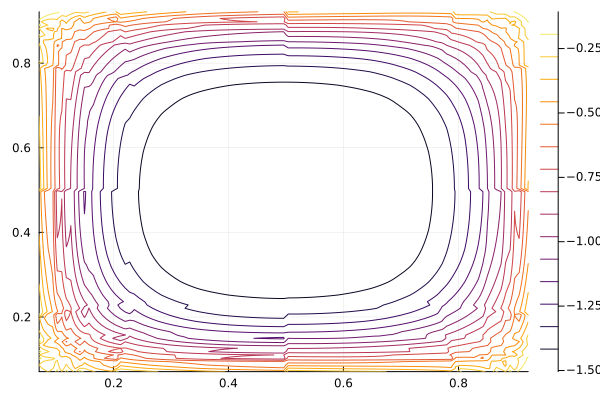

In [1516]:
contour(x₁[10:end-10], x₂[10:end-10], reshape(UT♯S[:,1],N,N)[10:end-10,10:end-10])

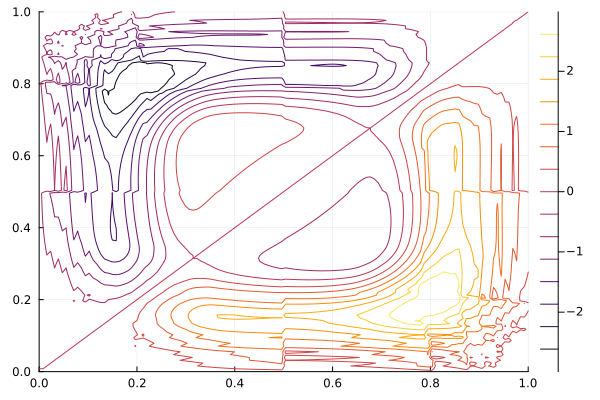

In [1517]:
contour(x₁, x₂, T⁻¹♯U[:,2])

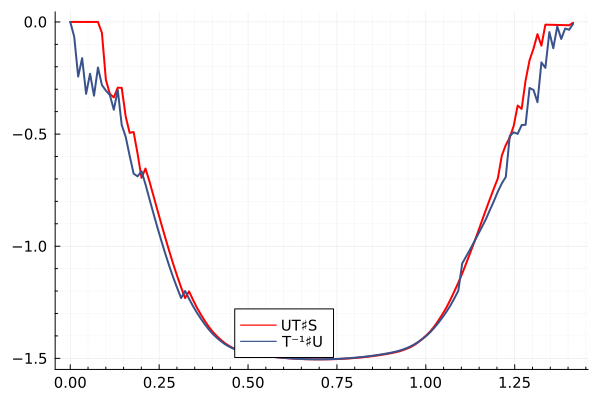

In [1518]:
plot(x₁ .* sqrt(2), diagslice( UT♯S[:,1] ), label = "UT♯S", linewidth=2, minorgrid = true, legend = :bottom,
    c=:red, legendfontsize=10, tickfontsize = 10)
plot!(x₁ .* sqrt(2), diagslice( T⁻¹♯U[:,1] ), label = "T⁻¹♯U", linewidth=2, c=pal[2])

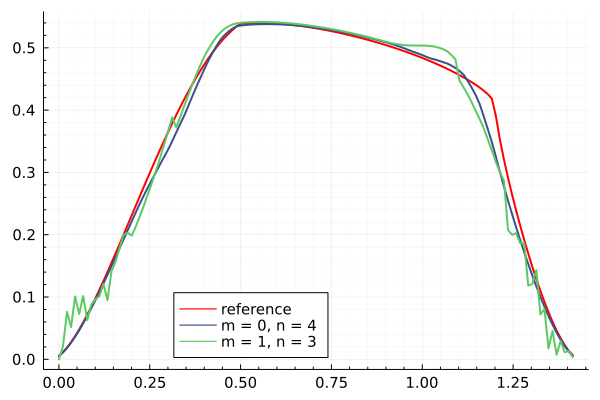

In [1519]:
function diagslice(f)
    f_d = zeros(N₁)
    for i in 1:N₁
        ij = li[ci[i,i]]
        f_d[i] = f[ij]
    end
    return f_d
end

plot(x₁ .* sqrt(2), diagslice(αᵢ), label = "reference", linewidth=2, minorgrid = true, legend=:bottom,
    c=:red, legendfontsize=10, tickfontsize = 10)
plot!(x₁ .* sqrt(2), diagslice(αpod), label = "m = 0, n = $(npod)", linewidth=2, c=pal[2])
plot!(x₁ .* sqrt(2), diagslice(αₐ), label = "m = $m, n = $n", linewidth=2, c=pal[4])
#plot!(x₁ .* sqrt(2), diagslice(β), label = "σ", linewidth=2, c=pal[3])

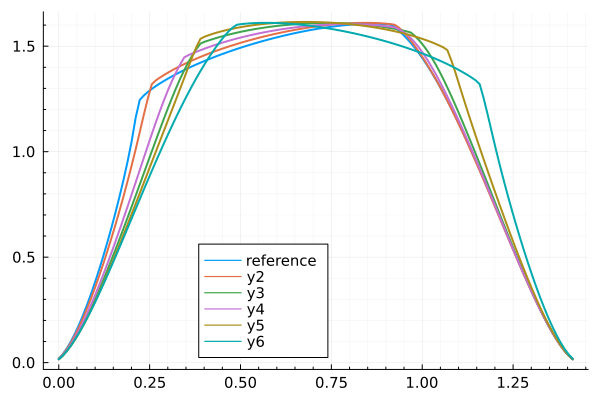

In [1503]:
plt = plot(x₁ .* sqrt(2), diagslice(α[1]), label = "reference", linewidth=2, minorgrid = true, legend=:bottom,
    legendfontsize=10, tickfontsize = 10)
for s in 2:10:nₛ
    plot!(x₁ .* sqrt(2), diagslice(α[s]), linewidth=2)
end
plt


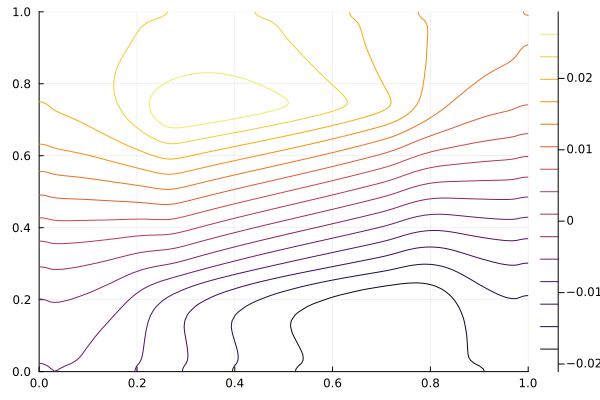

In [1316]:
contour(x₁, x₂, ψᶜ[i_test])

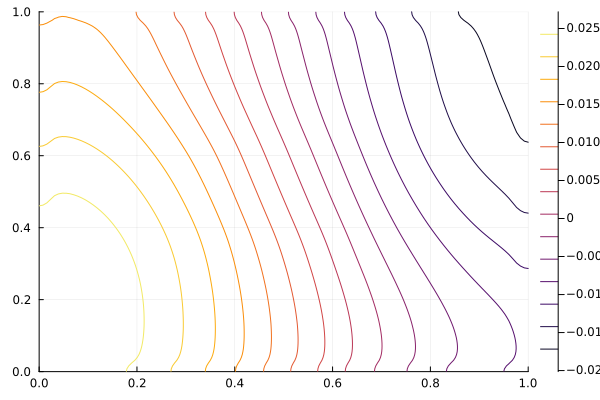

In [957]:
contour(x₁, x₂, ψᶜλ[i_test])

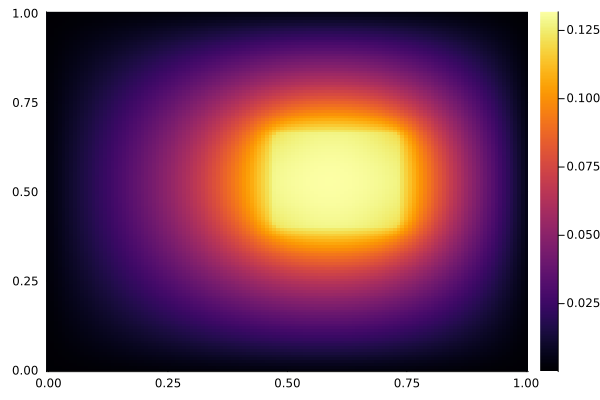

In [958]:
heatmap(x₁, x₂, reshape( S[:,i_test] , N₁, N₂))

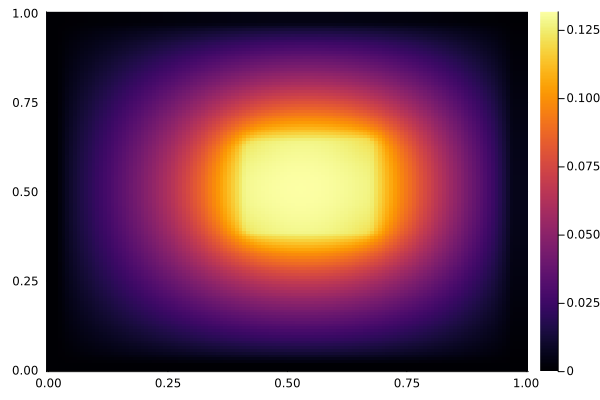

In [959]:
heatmap(x₁, x₂, reshape( T♯S[:,i_test] , N₁, N₂))

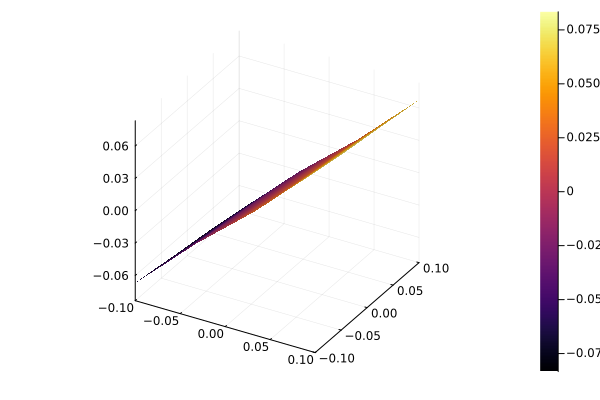

In [960]:
surface(μ₁, μ₂, [ λ[s][1] for s in eachindex(α) ])

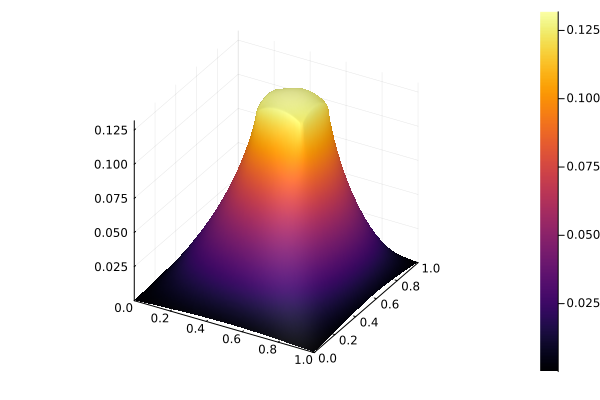

In [961]:
surface(x₁, x₂, αᵢ)

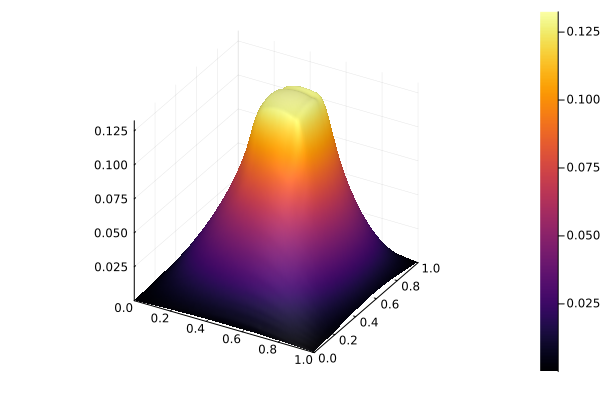

In [962]:
surface(x₁, x₂, αₐ)

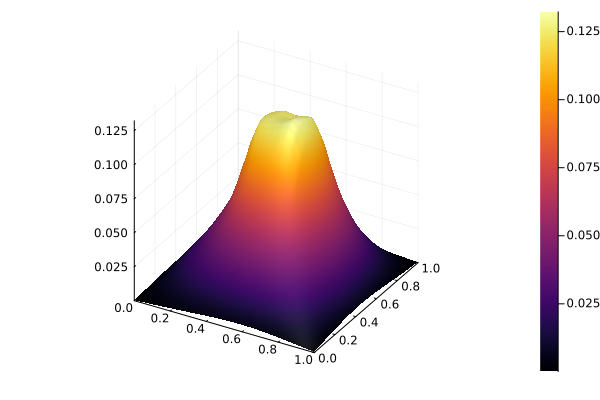

In [924]:
surface(x₁, x₂, αpod)

In [1595]:
m_max = 4   # number of transport modes
n_max = 10  # number of RB elements in reference configuration
Δnₛ = 16 # use every _th snapshot to calculate the average error

nₚ_plot = length(1:Δnₛ:nₛ)

δ_f = zeros(m_max + 1, n_max, nₚ_plot)
Λ_opt = [ zeros(_m, length(ψᶜ)) for _m in 1:m_max ]

for m in 0:m_max

    if m == 0 # POD
        
        T♯S = copy(S)
    
    else

        # transport basis
        Ξ = UΨᶜ[:,1:m]
        # transport coefficients
        λ = [ - h₁ * h₂ * Ξ' * ∇σ∇ * vec(ψᶜ[s]) for s in eachindex(ψᶜ) ]
        for s in eachindex(ψᶜ)
            Λ_opt[m][:,s] .= λ[s]
        end
        
        # approximate mappings from reference configuration 
        ψᶜλ = [ reshape(Ξ * λ[s], N₁, N₂) for s in eachindex(ψᶜ) ];
        # approximate mappingsto reference configuration
        ψλ = [ones(size(α[s])) for s in eachindex(α)]
        for s in eachindex(ψλ)
            WassersteinDictionaries.softmin_separated!(ψλ[s], ψᶜλ[s], log.(β), 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64])
        end

        # snapshots in the reference frame
        T♯S = zero(S)
        T♯Sᵢ = zeros(N₁*N₂)
        for i in eachindex(α)
            _∇ψ♯!(T♯Sᵢ, S[:,i], vec(ψᶜλ[i]))
            T♯S[:,i] .= T♯Sᵢ
        end

    end

    # get the reduced Basis
    evdT♯S = eigen( T♯S' * T♯S * h₁ * h₂, sortby = x -> -abs(x) )
    ΛT♯S = evdT♯S.values
    ET♯S = [ sum(ΛT♯S[1:k]) / sum(ΛT♯S) for k in 1:length(ΛT♯S)]
    UT♯S = T♯S * evdT♯S.vectors * diagm(1 ./ sqrt.(abs.(ΛT♯S)) )

    if m == 0 # POD
        
        T⁻¹♯U = copy(UT♯S)
    
    else

        log_β = log.(β)

        ψᶜᵢ = zero(ψᶜλ[1])
        ψᵢ = zero(ψλ[1])

        # reference basis moved back
        T⁻¹♯U = zeros(N₁*N₂, n_max) 
        uⱼ = zeros(N₁*N₂)
        T⁻¹♯uⱼ = zeros(N₁*N₂)

    end

    _i = 1
    # loop over the test set
    for i_test in 1:Δnₛ:nₛ

        αᵢ = S[:,i_test]
        
        if m != 0

            ψᶜᵢ .= ψᶜλ[i_test]
            ψᵢ .= 0.0
            WassersteinDictionaries.softmin_separated!(ψᵢ, ψᶜᵢ, log_β, 1e-8, c, caches.VC[:t1,Float64], caches.MC[:t2,Float64]);

            for j in 1:n_max
                uⱼ .= UT♯S[:,j]
                _∇ψ♯!(T⁻¹♯uⱼ, uⱼ, vec(ψᵢ))
                T⁻¹♯U[:,j] .= T⁻¹♯uⱼ
            end

        end

        # loop over RB size
        for n in 1:n_max
            A = T⁻¹♯U[:,1:n]
            a = (A' * A) \ (A' * αᵢ );
            αₐ = A * a
            δ_f[m+1, n, _i] = norm(αₐ - αᵢ) * sqrt(h₁ * h₂)
        end

        _i += 1
    end

end

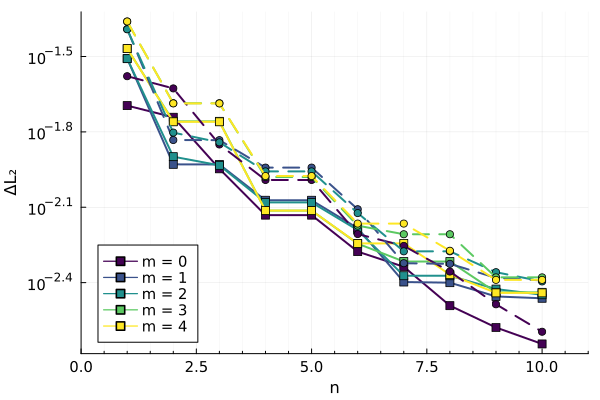

In [1851]:
δ_f_avg = sum(δ_f, dims=3) ./ nₚ_plot;
δ_f_sd = std(δ_f, dims=3)
δ_f_max = maximum(δ_f, dims=3);

plt = plot( δ_f_avg[1,:], yaxis=:log, xlabel = "n", ylabel = "ΔL₂", c= pal[1], xlim = (0,n_max+1),
#ribbon = δ_f_sd[1,:],fillalpha = 0.2, 
linewidth=2, marker = :square, legend = :bottomleft, label = "m = 0", minorgrid = true, legendfontsize=10, tickfontsize = 10) 
for m in 1:m_max
    plot!( δ_f_avg[m+1,:] , 
    #ribbon = δ_f_sd[m+1,:], fillalpha = 0.2, 
    linewidth=2, marker = :square, label = "m = $(m)",c=pal[m+1])
end
for m in 0:m_max
    plot!( δ_f_max[m+1,:], line=:dash, linewidth=2, marker = :circle, label = false,c=pal[m+1])
end

plt